# This notebook demonstrates how to train class version of buddi4 model from buddi_v2

In [1]:
import os
import sys
import pathlib
import joblib
import subprocess
import re
from collections import defaultdict

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import umap.umap_ as umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from matplotlib_venn import venn2, venn3
import seaborn as sns

"""Remove line below to use GPU"""
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # This LINE disables GPU
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import CategoricalCrossentropy, MeanAbsoluteError

2025-05-23 13:29:12.773531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 13:29:12.782117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748028552.791518 1970746 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748028552.794516 1970746 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748028552.802191 1970746 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
GENE_ID_COL = 'gene_ids'
TECH_COL = 'samp_type'

## Add buddi_v2 software to path

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)
BUDDI_PATH = REPO_ROOT / "src"

sys.path.insert(0, str(BUDDI_PATH))

from buddi_v2.data import BuDDINData
from buddi_v2.dataset.buddi3_dataset import get_supervised_dataset, get_unsupervised_dataset
from buddi_v2.models.components.losses import kl_loss
from buddi_v2.models.buddi3_class import BuDDI3
from buddi_v2.models.fit import fit_buddi
from buddi_v2.plotting.plot_loss import plot_loss
from buddi_v2.plotting.plot_latent_space import plot_latent_spaces_buddi

## Pre-Processing Output

In [4]:
## Input data path
DATA_PATH = REPO_ROOT / 'examples' / 'example_data'
assert DATA_PATH.exists()

### Load train data

In [ ]:
train_data = joblib.load(DATA_PATH / "buddi3_data.pkl")
train_data.reset_query()
train_data

BuDDINData(selected samples=3649/3649, genes=7000, cell_types=8)

### Supervised vs Unsupervised split & Dataset Generation

In [6]:
(
    X_kp,
    y_kp,
    sample_id_kp,
    samp_type_kp,
    meta_kp
) = train_data.reset_query().query(
    isTraining='Train',
    samp_type='sc_ref'
).get(('X', 'y', SAMPLE_ID_COL, TECH_COL, 'meta'))

(
    X_unkp,
    y_unkp,
    sample_id_unkp,
    samp_type_unkp,
    meta_unkp
) = train_data.reset_query().query(
    isTraining='Train',
    samp_type='bulk'
).get(('X', 'y', SAMPLE_ID_COL, TECH_COL, 'meta'))

Generating Tensorflow `dataset` objects for BuDDI4 training (**note** `ds_sup` and `ds_unsup` do not work with plotting or model inference out of the box), use raw data (e.g. `X_kp`, `X_unkp`) instead for these purposes.

In [7]:
ds_sup = get_supervised_dataset(
    X_known_prop=X_kp,
    Y_known_prop=y_kp,
    label_known_prop=sample_id_kp,
    samp_type_known_prop=samp_type_kp,
)
print(f"Number of entries in supervised dataset: {ds_sup.cardinality().numpy()}")
ds_sup_batch_x, ds_sup_batch_y = next(iter(ds_sup))

ds_unsup = get_unsupervised_dataset(
    X_unknown_prop=X_unkp,
    label_unknown_prop=sample_id_unkp,
    samp_type_unknown_prop=samp_type_unkp,
)
print(f"Number of entries in unsupervised dataset: {ds_unsup.cardinality().numpy()}")

print("\nTake a peek at the dataset generator return:\n")

ds_sup_batch_input, ds_sup_batch_target = next(iter(ds_sup.batch(16).take(1)))
ds_sup_batch_x, ds_sup_batch_y = ds_sup_batch_input
print(f"Supervised batch x shape: {ds_sup_batch_x.shape}")
print(f"Supervised batch y shape: {ds_sup_batch_y.shape}")
ds_sup_batch_target_x, _, _, _, ds_sup_batch_label, ds_sup_batch_samp_type, ds_sup_batch_target_y = ds_sup_batch_target
print(f"Supervised batch target x shape: {ds_sup_batch_target_x.shape}")
print(f"Supervised batch target y shape: {ds_sup_batch_target_y.shape}")
print(f"Supervised batch label shape: {ds_sup_batch_label.shape}")
print(f"Supervised batch samp_type shape: {ds_sup_batch_samp_type.shape}")

print("\n")

ds_unsup_batch_input, ds_unsup_batch_target = next(iter(ds_unsup.batch(16).take(1)))
ds_unsup_batch_x, = ds_unsup_batch_input
print(f"Unsupervised batch x shape: {ds_unsup_batch_x.shape}")
ds_unsup_batch_target_x, _, _, _, ds_unsup_batch_label, ds_unsup_batch_samp_type, _ = ds_unsup_batch_target
print(f"Unsupervised batch target x shape: {ds_unsup_batch_target_x.shape}")
print(f"Unsupervised batch label shape: {ds_unsup_batch_label.shape}")
print(f"Unsupervised batch samp_type shape: {ds_unsup_batch_samp_type.shape}")

Number of entries in supervised dataset: 1800
Number of entries in unsupervised dataset: 49

Take a peek at the dataset generator return:

Supervised batch x shape: (16, 7000)
Supervised batch y shape: (16, 8)
Supervised batch target x shape: (16, 7000)
Supervised batch target y shape: (16, 8)
Supervised batch label shape: (16, 51)
Supervised batch samp_type shape: (16, 2)


Unsupervised batch x shape: (16, 7000)
Unsupervised batch target x shape: (16, 7000)
Unsupervised batch label shape: (16, 51)
Unsupervised batch samp_type shape: (16, 2)


2025-05-23 13:29:13.688656: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-23 13:29:13.688672: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-05-23 13:29:13.688676: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-05-23 13:29:13.688679: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-05-23 13:29:13.688682: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: pop-os
2025-05-23 13:29:13.688683: I external/local_xla/xla/stream_executor/cuda/cuda_d

## BuDDI Training

### Instantiate Model

In [8]:
train_data._encode_fields

['sample_id', 'samp_type']

In [9]:
n_x = train_data.shape['X']
n_y = train_data.shape['y']
n_sample_ids = train_data.shape['n_sample_id']
n_samp_types = train_data.shape['n_samp_type']

In [10]:
obj = BuDDI3(
    n_x=n_x,
    n_y=n_y,
    z_dim=64,
    encoder_hidden_dim=512,
    decoder_hidden_dim=512,
    activation='relu',
    output_activation='sigmoid',
    n_sample_ids=n_sample_ids,
    n_samp_types=n_samp_types,
)

In [11]:
obj.print_loss_table()

Loss Name       Function                    Weight
--------------------------------------------------
x_hat_sup       MeanAbsoluteError           1.0  
x_hat_unsup     MeanAbsoluteError           1.0  
y_hat           CategoricalCrossentropy     1.0  
y_dummy         unsupervised_dummy_loss_fn  0.0  
kl_sample_id    kl_loss                     1.0  
sample_id_pred  CategoricalCrossentropy     1.0  
kl_samp_type    kl_loss                     1.0  
samp_type_pred  CategoricalCrossentropy     1.0  
kl_slack        kl_loss                     0.1  


### Configure Losses

In [12]:
ALPHA = 100.0
ALPHA_X = 1.0

BETA = 100.0
BETA_SAMPLE = 10.0
BETA_SLACK = 0.1

obj.set_reconstruction_loss(
    fn=MeanAbsoluteError(reduction='sum'),
    weight=ALPHA_X,
)
obj.set_encoder_loss(
    branch_name=[
        TECH_COL
    ],
    fn=kl_loss,
    weight=BETA,    
)
obj.set_encoder_loss(
    branch_name=[
        SAMPLE_ID_COL
    ],
    fn=kl_loss,
    weight=BETA_SAMPLE,
)
obj.set_encoder_loss(
    branch_name='slack',
    fn=kl_loss,
    weight=BETA_SLACK,
)
obj.set_predictor_loss(
    branch_name=[
        SAMPLE_ID_COL,
        TECH_COL
    ],
    fn=CategoricalCrossentropy(reduction='sum'),
    weight=ALPHA
)
obj.set_prop_estimator_loss(
    fn=CategoricalCrossentropy(reduction='sum'),
    weight=ALPHA,
)

obj.print_loss_table()

Loss Name       Function                    Weight 
---------------------------------------------------
x_hat_sup       MeanAbsoluteError           1.0    
x_hat_unsup     MeanAbsoluteError           1.0    
y_hat           CategoricalCrossentropy     100.0  
y_dummy         unsupervised_dummy_loss_fn  0.0    
kl_sample_id    kl_loss                     10.0   
sample_id_pred  CategoricalCrossentropy     100.0  
kl_samp_type    kl_loss                     100.0  
samp_type_pred  CategoricalCrossentropy     100.0  
kl_slack        kl_loss                     0.1    


### Compile

In [13]:
obj.compile(optimizer=Adam(learning_rate=0.0005))

### Visualize connection

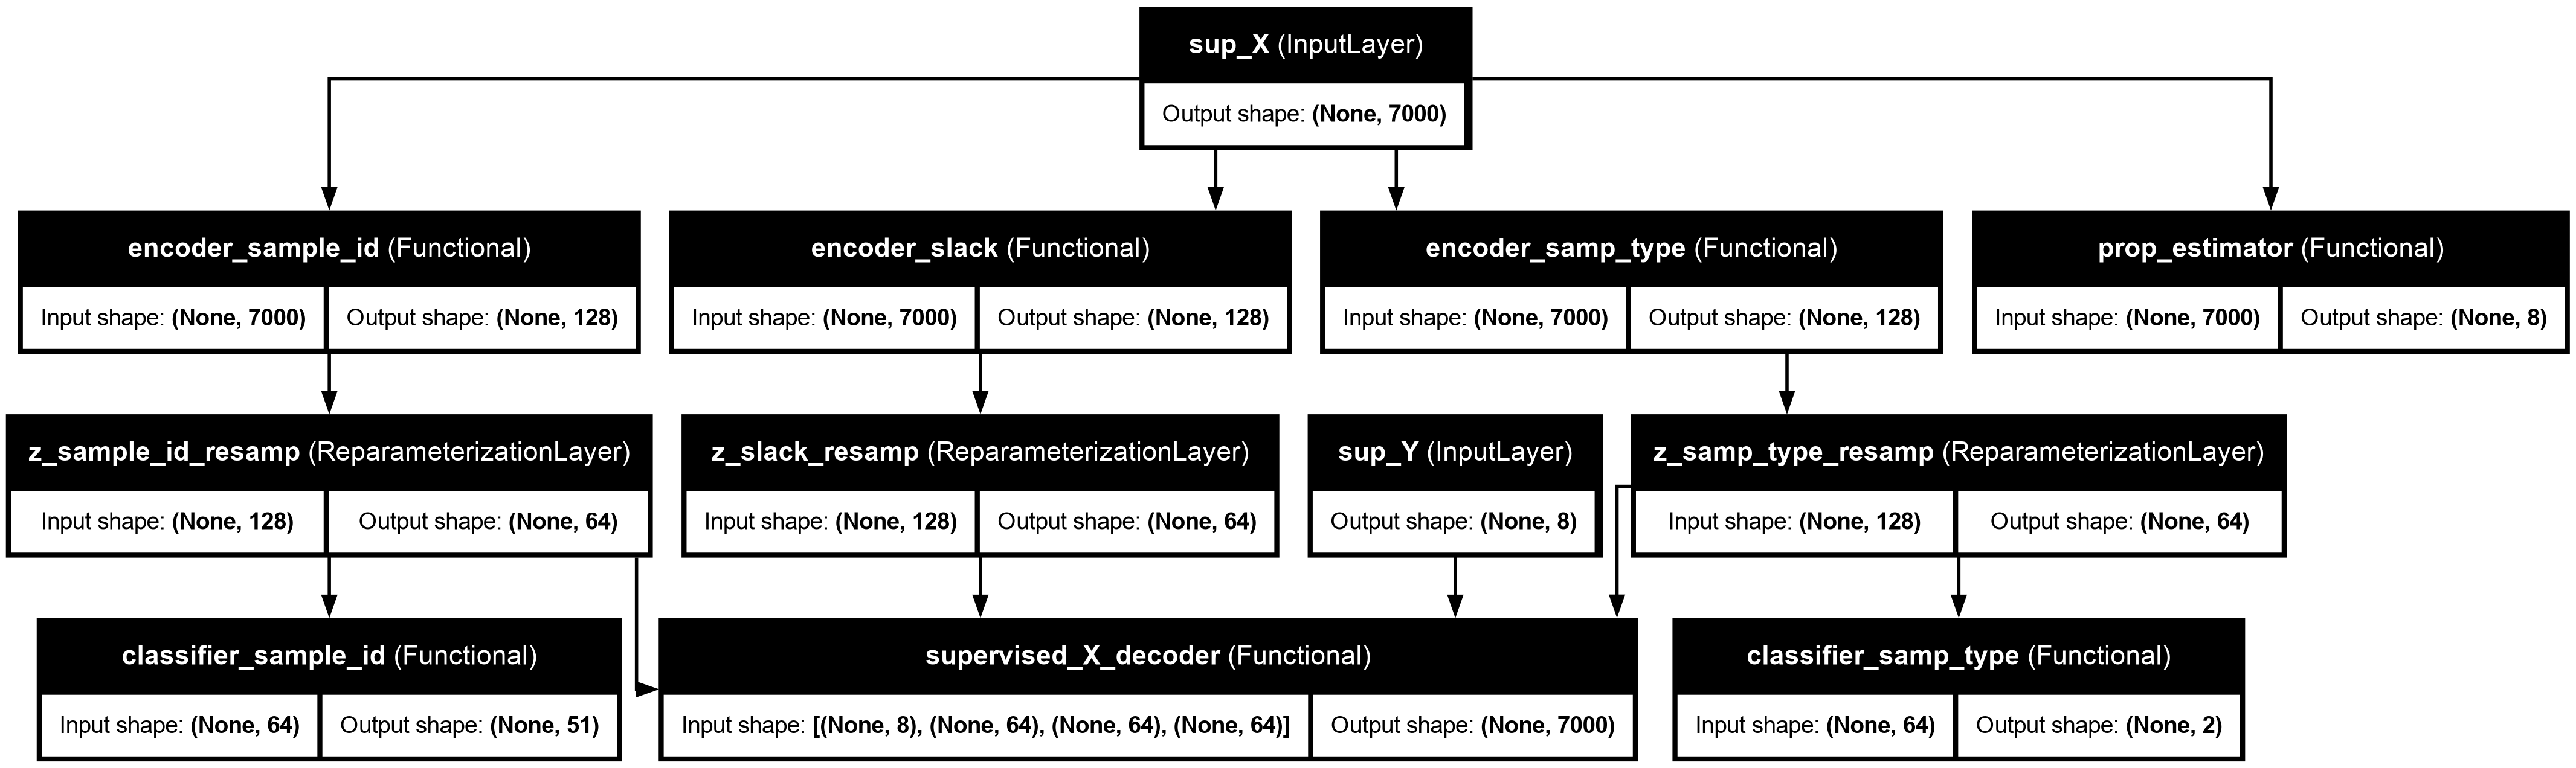

In [14]:
plot_model(
    obj.sup_model, 
    show_shapes=True,
    show_layer_names=True,
)

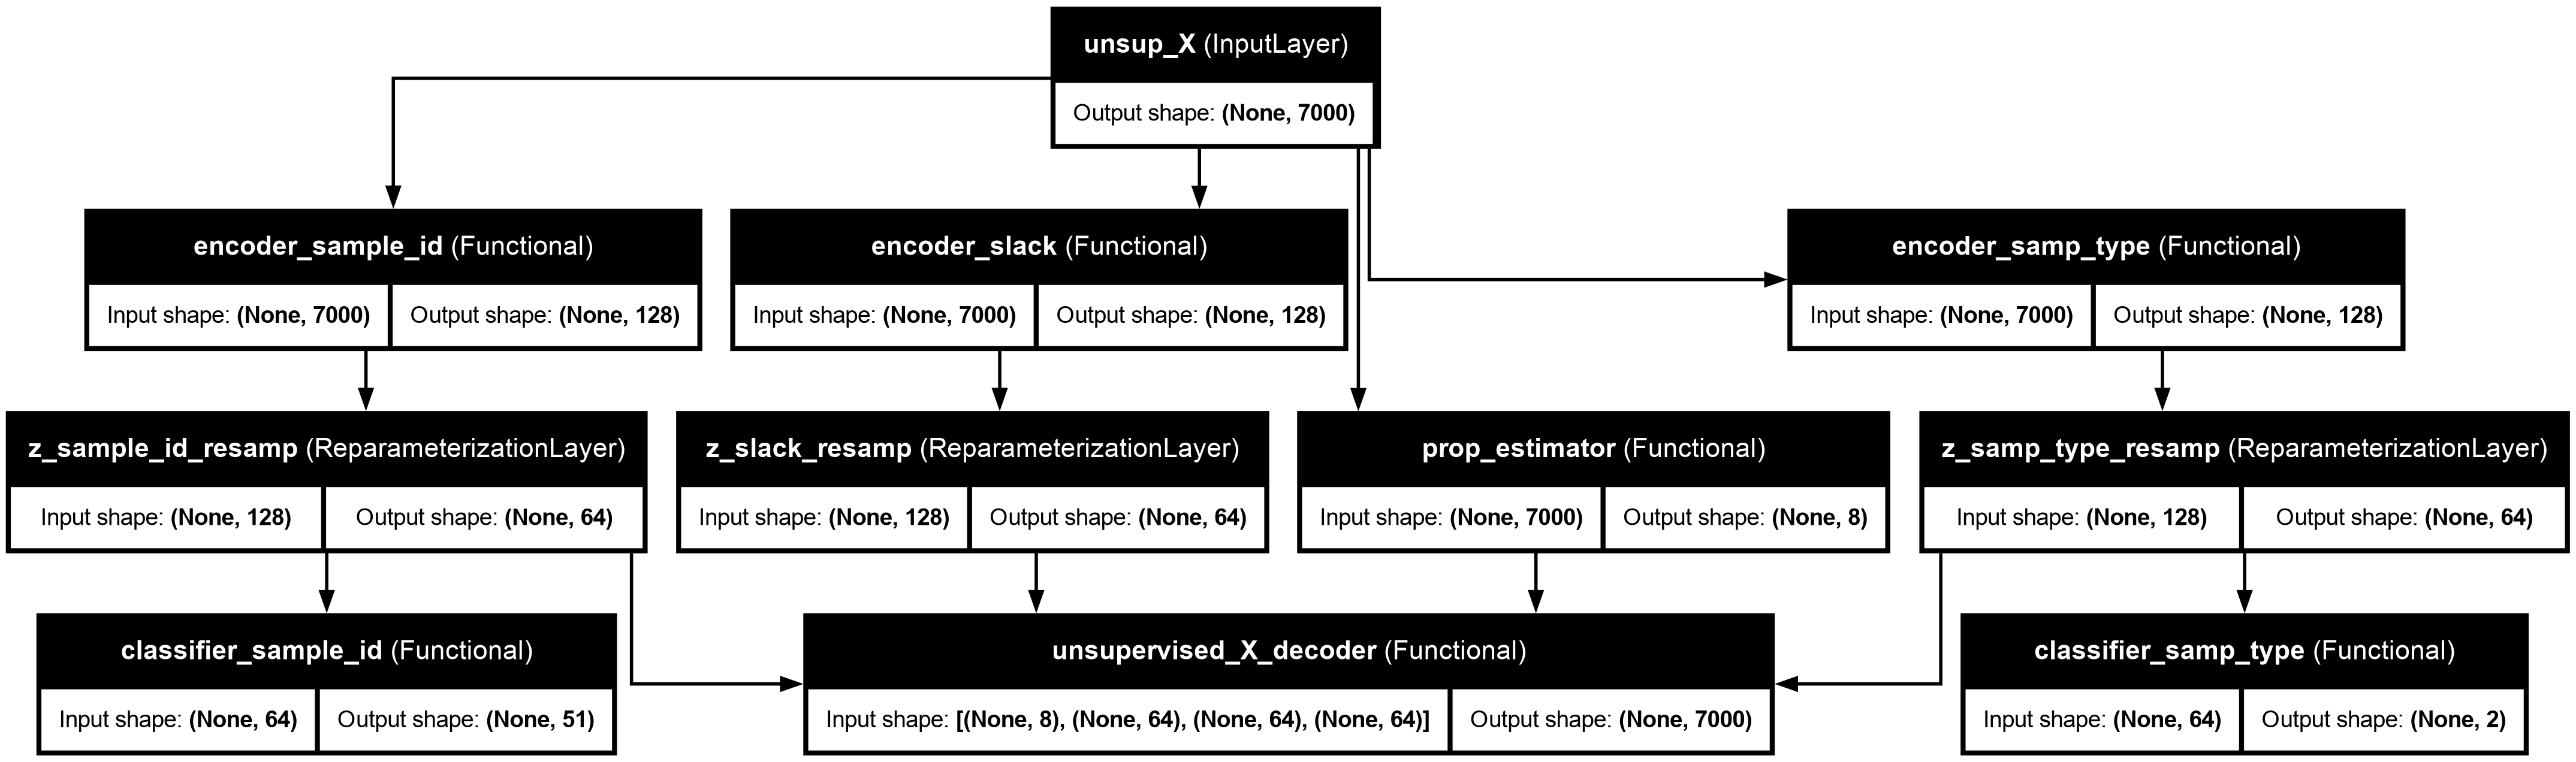

In [15]:
plot_model(
    obj.unsup_model, 
    show_shapes=True,
    show_layer_names=True,
)

In [16]:
!rm model.png

In [17]:
ds_test_sup = None
if train_data.reset_query().query(
        isTraining='Test',
        samp_type='sc_ref'
    ).__len__() > 0:

    (
        test_X_kp,
        test_y_kp,
        test_sample_id_kp,
        test_samp_type_kp
    ) = train_data.get(
        ('X', 'y', SAMPLE_ID_COL, TECH_COL)
    )

    ds_test_sup = get_supervised_dataset(
        X_known_prop=test_X_kp,
        Y_known_prop=test_y_kp,
        label_known_prop=test_sample_id_kp,
        samp_type_known_prop=test_samp_type_kp,
    )

ds_test_unsup = None
if train_data.reset_query().query(
        isTraining='Test',
        samp_type='bulk'
    ).__len__() > 0:

    (
        test_X_unkp,
        test_y_unkp,
        test_sample_id_unkp,
        test_samp_type_unkp
    ) = train_data.get(
        ('X', 'y', SAMPLE_ID_COL, TECH_COL)
    )

    ds_test_unsup = get_unsupervised_dataset(
        X_unknown_prop=test_X_unkp,
        label_unknown_prop=test_sample_id_unkp,
        samp_type_unknown_prop=test_samp_type_unkp,
    )

### Train Model

In [18]:
all_loss_df = fit_buddi(
    supervised_model=obj.sup_model,
    unsupervised_model=obj.unsup_model,
    dataset_supervised=ds_sup,
    dataset_unsupervised=ds_unsup,
    dataset_test_supervised=ds_test_sup,
    dataset_test_unsupervised=ds_test_unsup,
    epochs=10,
    batch_size=16,
    shuffle_every_epoch=True,
    prefetch=False
)

Epoch 1/10:   0%|          | 0/113 [00:00<?, ?it/s]

Testing supervised model: 100%|██████████| 113/113 [00:01<00:00, 89.88it/s]

Training complete!


In [19]:
all_loss_df.head()

,loss,X_reconstruction_loss,encoder_sample_id_loss,encoder_samp_type_loss,encoder_slack_loss,classifier_sample_id_loss,classifier_samp_type_loss,prop_estimator_loss,epoch,batch,type,split
0,12709.291992,5.198377,12.105149,14.917477,17.799747,59.955055,13.982735,36.957359,0,0,supervised,train
1,13217.323242,4.879373,91.157677,34.115807,27.310217,33.016918,7.095748,48.752899,0,1,supervised,train
2,12398.059570,4.685077,97.218575,27.932386,21.055468,24.157196,6.869595,55.231659,0,2,supervised,train
3,11183.435547,4.579342,95.570358,23.415991,16.790882,19.523031,7.519647,51.756065,0,3,supervised,train
4,10581.436523,4.415277,100.700851,20.374954,13.759253,15.967122,7.550882,51.793407,0,4,supervised,train


### Examine Reconstruction

**Optional**: For seeded determinstic behavior, do:
```python
obj.set_reparam_deterministic(deterministic=True, seed=42)
```
To go back to stochastic, simply do:
```python
obj.set_reparam_deterministic(deterministic=False)
```

In [20]:
(
    x_hat,
    z_param_label,
    z_param_samp_type,
    z_param_slack,
    pred_label,
    pred_samp_type,
    y_hat
) = obj.unsup_model(
    ds_unsup_batch_input
)
print(f"Predicted x shape: {x_hat.shape}")
print(f"Predicted z_param_label shape: {z_param_label.shape}")
print(f"Predicted z_param_samp_type shape: {z_param_samp_type.shape}")
print(f"Predicted z_param_slack shape: {z_param_slack.shape}")
print(f"Predicted pred_label shape: {pred_label.shape}")
print(f"Predicted pred_samp_type shape: {pred_samp_type.shape}")
print(f"Predicted y_hat shape: {y_hat.shape}")

Predicted x shape: (16, 7000)
Predicted z_param_label shape: (16, 128)
Predicted z_param_samp_type shape: (16, 128)
Predicted z_param_slack shape: (16, 128)
Predicted pred_label shape: (16, 51)
Predicted pred_samp_type shape: (16, 2)
Predicted y_hat shape: (16, 8)


### Visualize latent space of Train

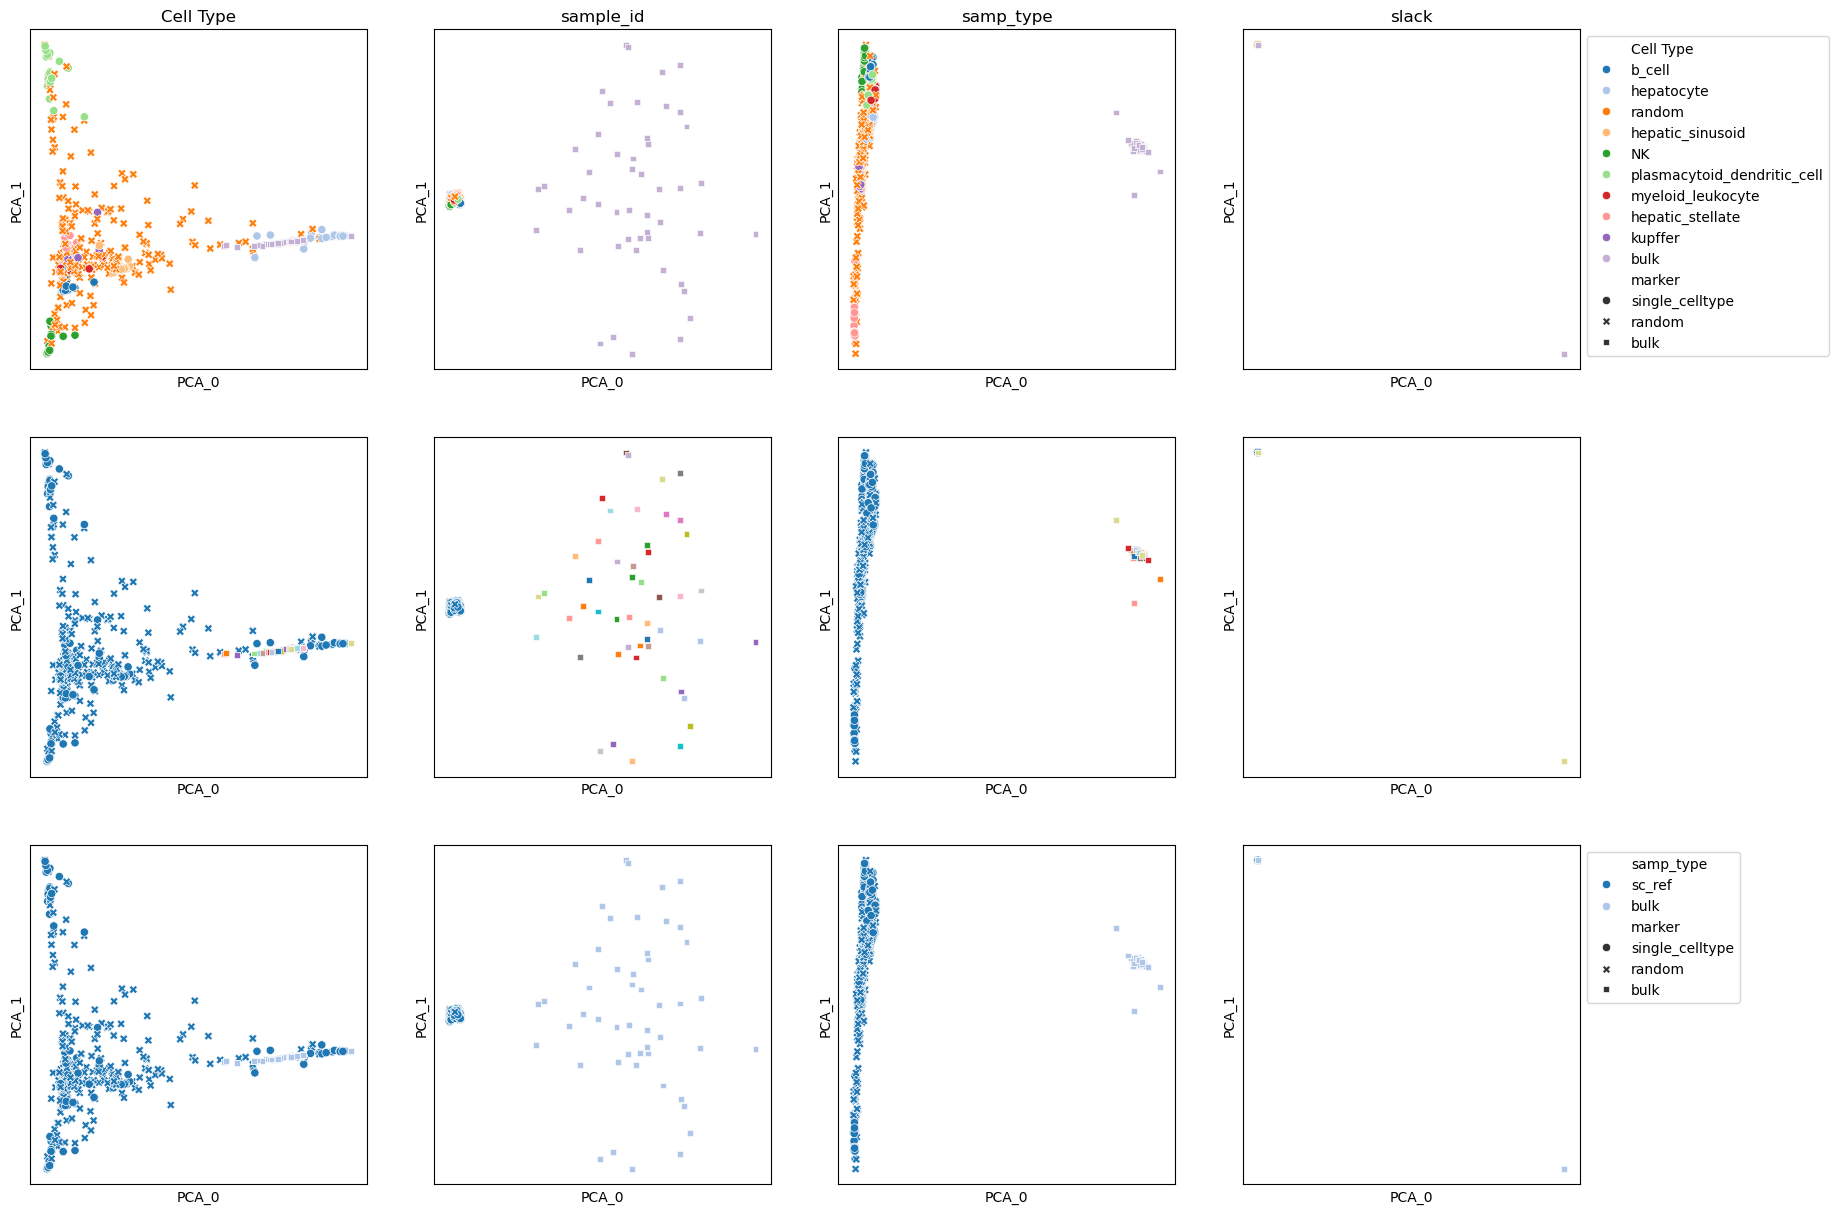

In [21]:
# Down-sample the sc_ref and bulk data for visualization
(
    X_kp_tmp,
    Y_kp_tmp,
    meta_kp_tmp
) = train_data.reset_query().query(
    isTraining='Train',
    samp_type='sc_ref'
).get(
    ('X', 'y', 'meta'),
    n_samples=500,
    replace=True,
    random_state=42
)

(
    X_unkp_tmp,
    Y_unkp_tmp,
    meta_unkp_tmp
) = train_data.reset_query().query(
    isTraining='Train',
    samp_type='bulk'
).get(
    ('X', 'y', 'meta'),
    n_samples=500,
    replace=True,
    random_state=42
)

cell_types = train_data.cell_type_names
X_tmp = np.concatenate((X_kp_tmp, X_unkp_tmp), axis=0)
Y_tmp = np.concatenate((Y_kp_tmp, Y_unkp_tmp), axis=0)
meta_tmp = pd.concat((meta_kp_tmp, meta_unkp_tmp), axis=0)


idx_sc_prop = np.where(meta_tmp.cell_prop_type == "single_celltype")[0]
cell_type_labels = [cell_types[i] for i in np.argmax(Y_tmp[idx_sc_prop, :], axis=1)]
cell_type_col = meta_tmp.loc[:,'cell_prop_type'].values.copy()
cell_type_col[idx_sc_prop] = cell_type_labels
meta_tmp.loc[:,'cell_type'] = cell_type_col

_ = plot_latent_spaces_buddi(
    obj,
    X_tmp=X_tmp,
    meta_tmp=meta_tmp,
    type='PCA',
    panel_width=5,
    show_plot=True,
    save_path=None
)

### Visualize latent space don't filter by split

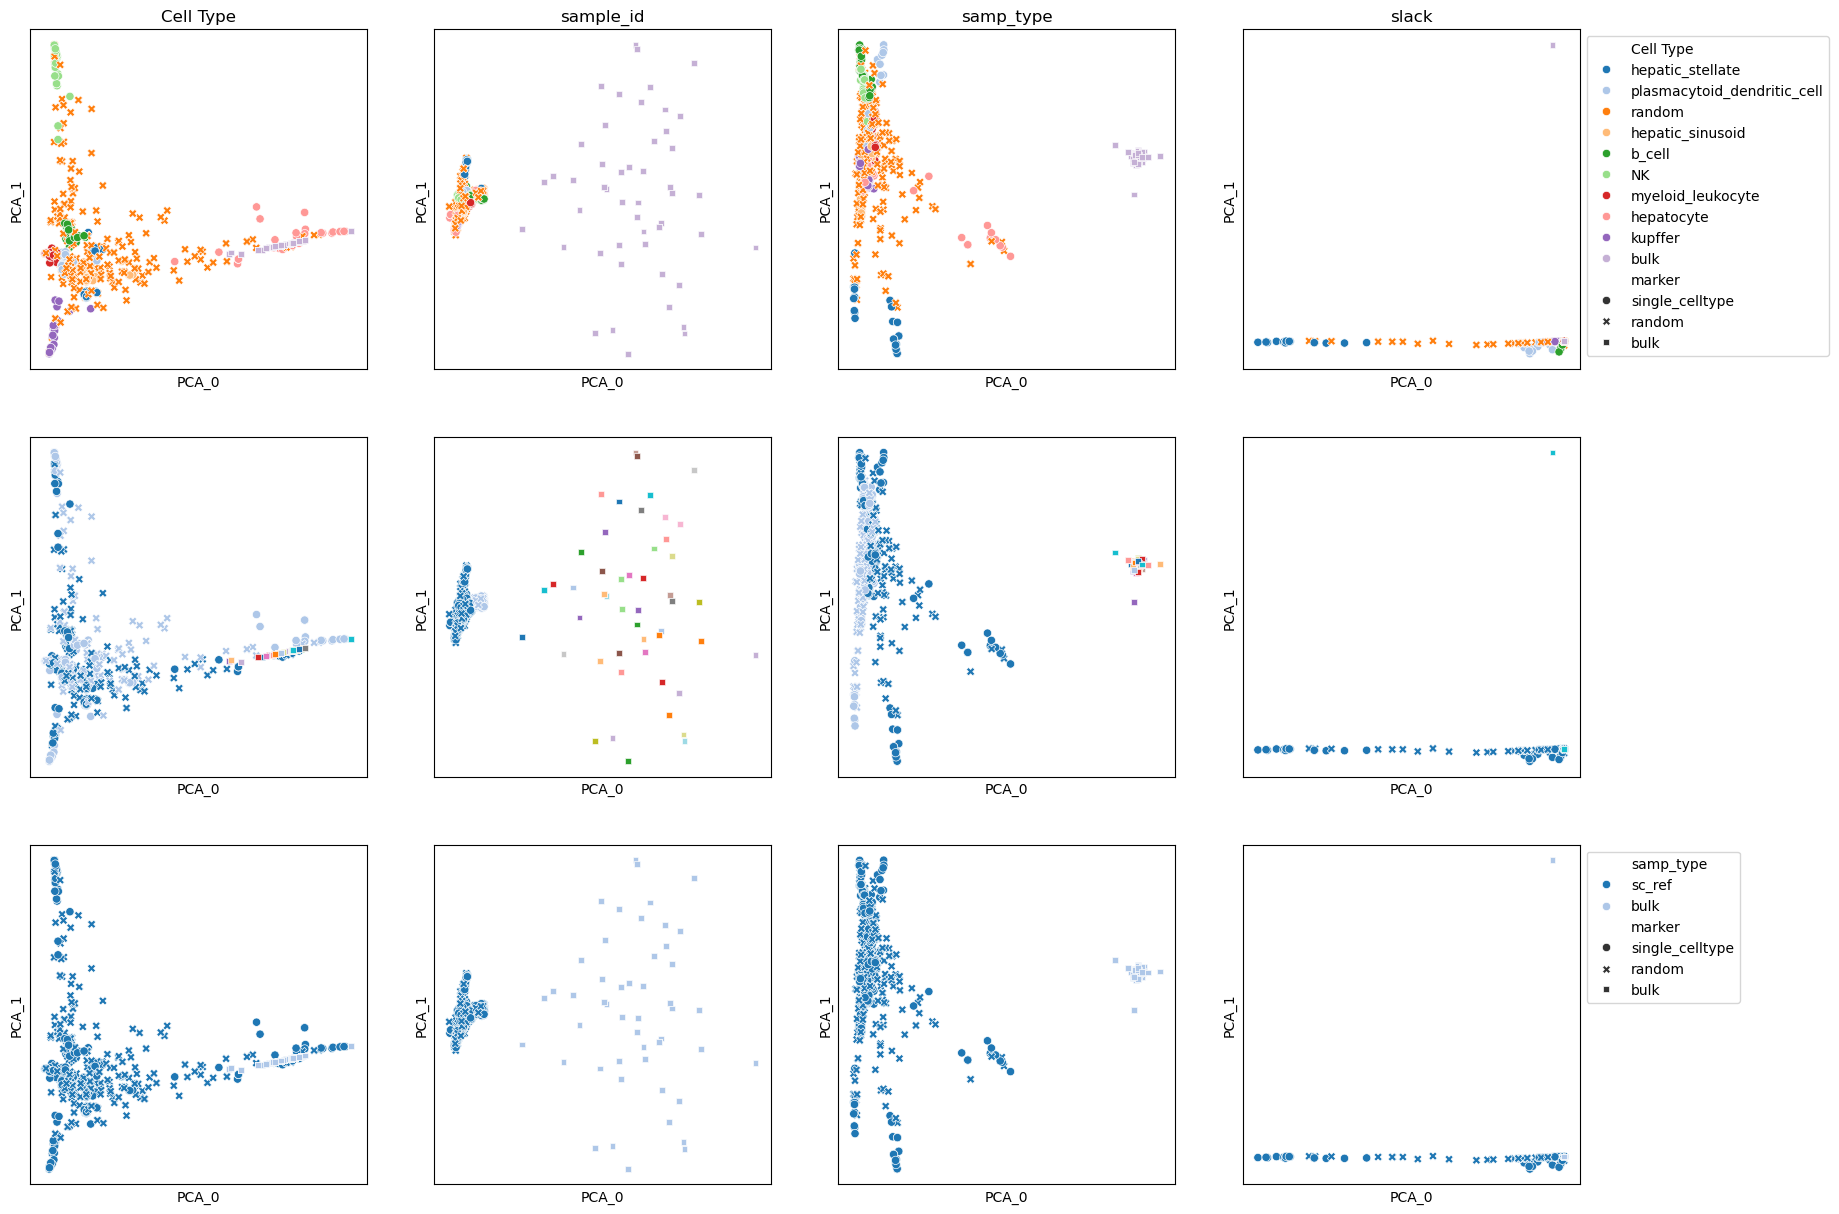

In [22]:
(
    X_kp_tmp,
    Y_kp_tmp,
    meta_kp_tmp
) = train_data.reset_query().query(
    samp_type='sc_ref'
).get(
    ('X', 'y', 'meta'),
    n_samples=500,
    replace=True,
    random_state=42
)

(
    X_unkp_tmp,
    Y_unkp_tmp,
    meta_unkp_tmp
) = train_data.reset_query().query(
    samp_type='bulk'
).get(
    ('X', 'y', 'meta'),
    n_samples=500,
    replace=True,
    random_state=42
)

cell_types = train_data.cell_type_names
X_tmp = np.concatenate((X_kp_tmp, X_unkp_tmp), axis=0)
Y_tmp = np.concatenate((Y_kp_tmp, Y_unkp_tmp), axis=0)
meta_tmp = pd.concat((meta_kp_tmp, meta_unkp_tmp), axis=0)


idx_sc_prop = np.where(meta_tmp.cell_prop_type == "single_celltype")[0]
cell_type_labels = [cell_types[i] for i in np.argmax(Y_tmp[idx_sc_prop, :], axis=1)]
cell_type_col = meta_tmp.loc[:,'cell_prop_type'].values.copy()
cell_type_col[idx_sc_prop] = cell_type_labels
meta_tmp.loc[:,'cell_type'] = cell_type_col

_ = plot_latent_spaces_buddi(
    obj,
    X_tmp=X_tmp,
    meta_tmp=meta_tmp,
    type='PCA',
    panel_width=5,
    show_plot=True,
    save_path=None
)

### Plot Train Loss

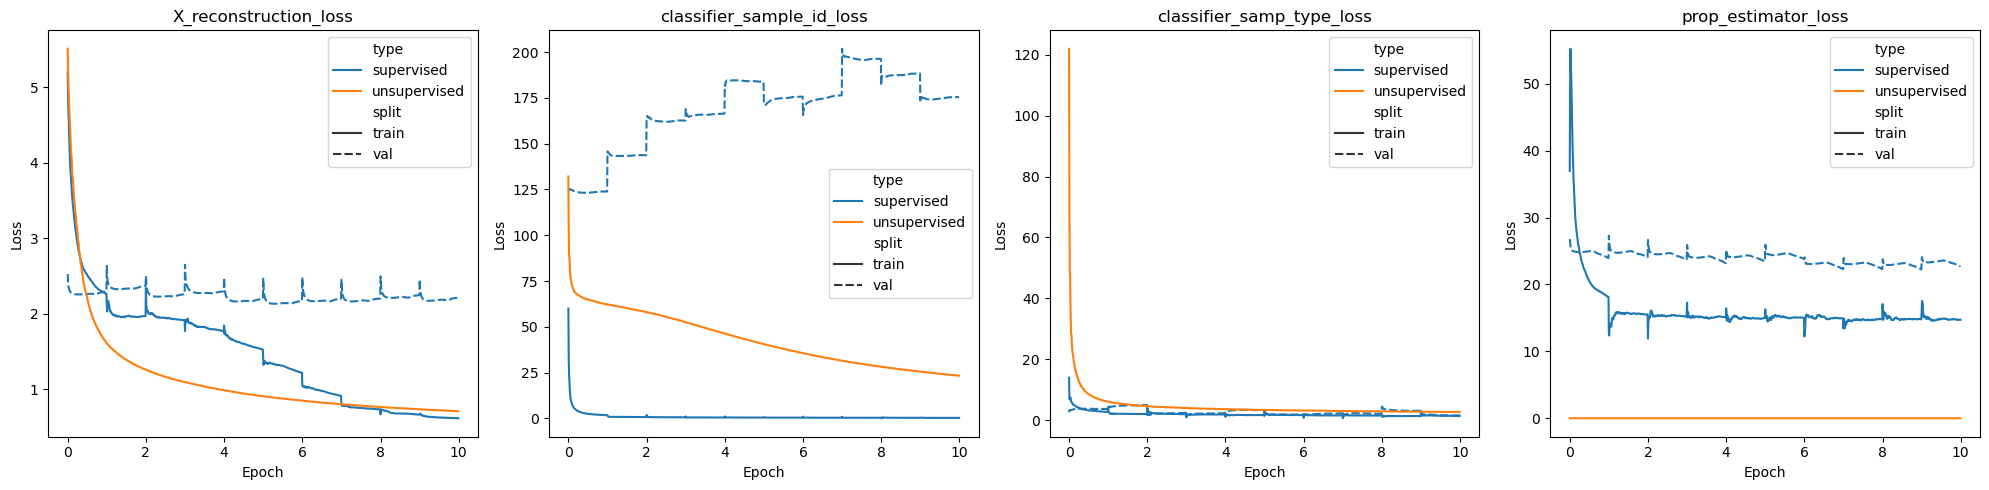

In [23]:
plot_loss(all_loss_df, save_path=None, show_plot=True)

### Saving BuDDI3 object

In [ ]:
obj.save(
    directory='temp'
)

Saved model structure looks like this

In [ ]:
print(os.listdir('temp'))

In [ ]:
!rm -rf temp

### To load saved object and weights, do

In [ ]:
# loaded_obj = BuDDI3.load(
#     directory='temp'
# )